In [1]:
image_size = 28
%load_ext autoreload

In [18]:
import numpy as np # linear algebra
import struct
from os.path import join
from typing import List
from tqdm import tqdm
import os
import shutil
import gzip

In [3]:
## Get MNIST Dataset

def get_unzipped_file_if_need(path: str):
  if not os.path.exists(path):
    with gzip.open(f"{path}.gz", "rb") as f_in:
      with open(path, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

get_unzipped_file_if_need("./datasets/mnist/t10k-images-idx3-ubyte")
get_unzipped_file_if_need("./datasets/mnist/t10k-labels-idx1-ubyte")
get_unzipped_file_if_need("./datasets/mnist/train-images-idx3-ubyte")
get_unzipped_file_if_need("./datasets/mnist/train-labels-idx1-ubyte")

In [4]:
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
  def __init__(self, training_images_filepath,training_labels_filepath,
                test_images_filepath, test_labels_filepath):
    self.training_images_filepath = training_images_filepath
    self.training_labels_filepath = training_labels_filepath
    self.test_images_filepath = test_images_filepath
    self.test_labels_filepath = test_labels_filepath
    
  def read_images_labels(self, images_filepath, labels_filepath):        
    labels = []
    with open(labels_filepath, 'rb') as file:
      magic, size = struct.unpack(">II", file.read(8))
      if magic != 2049:
        raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
      labels = np.frombuffer(file.read(), dtype=np.uint8)
    with open(images_filepath, 'rb') as file:
      magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
      if magic != 2051:
        raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
      assert rows == image_size
      assert rows == image_size
      images = np.frombuffer(file.read(), dtype=np.uint8).astype(np.float32)
      images = images.reshape(size, image_size, image_size, 1)         
    
    return images, labels
          
  def load_data(self):
    x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
    x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
    return (x_train, y_train),(x_test, y_test)

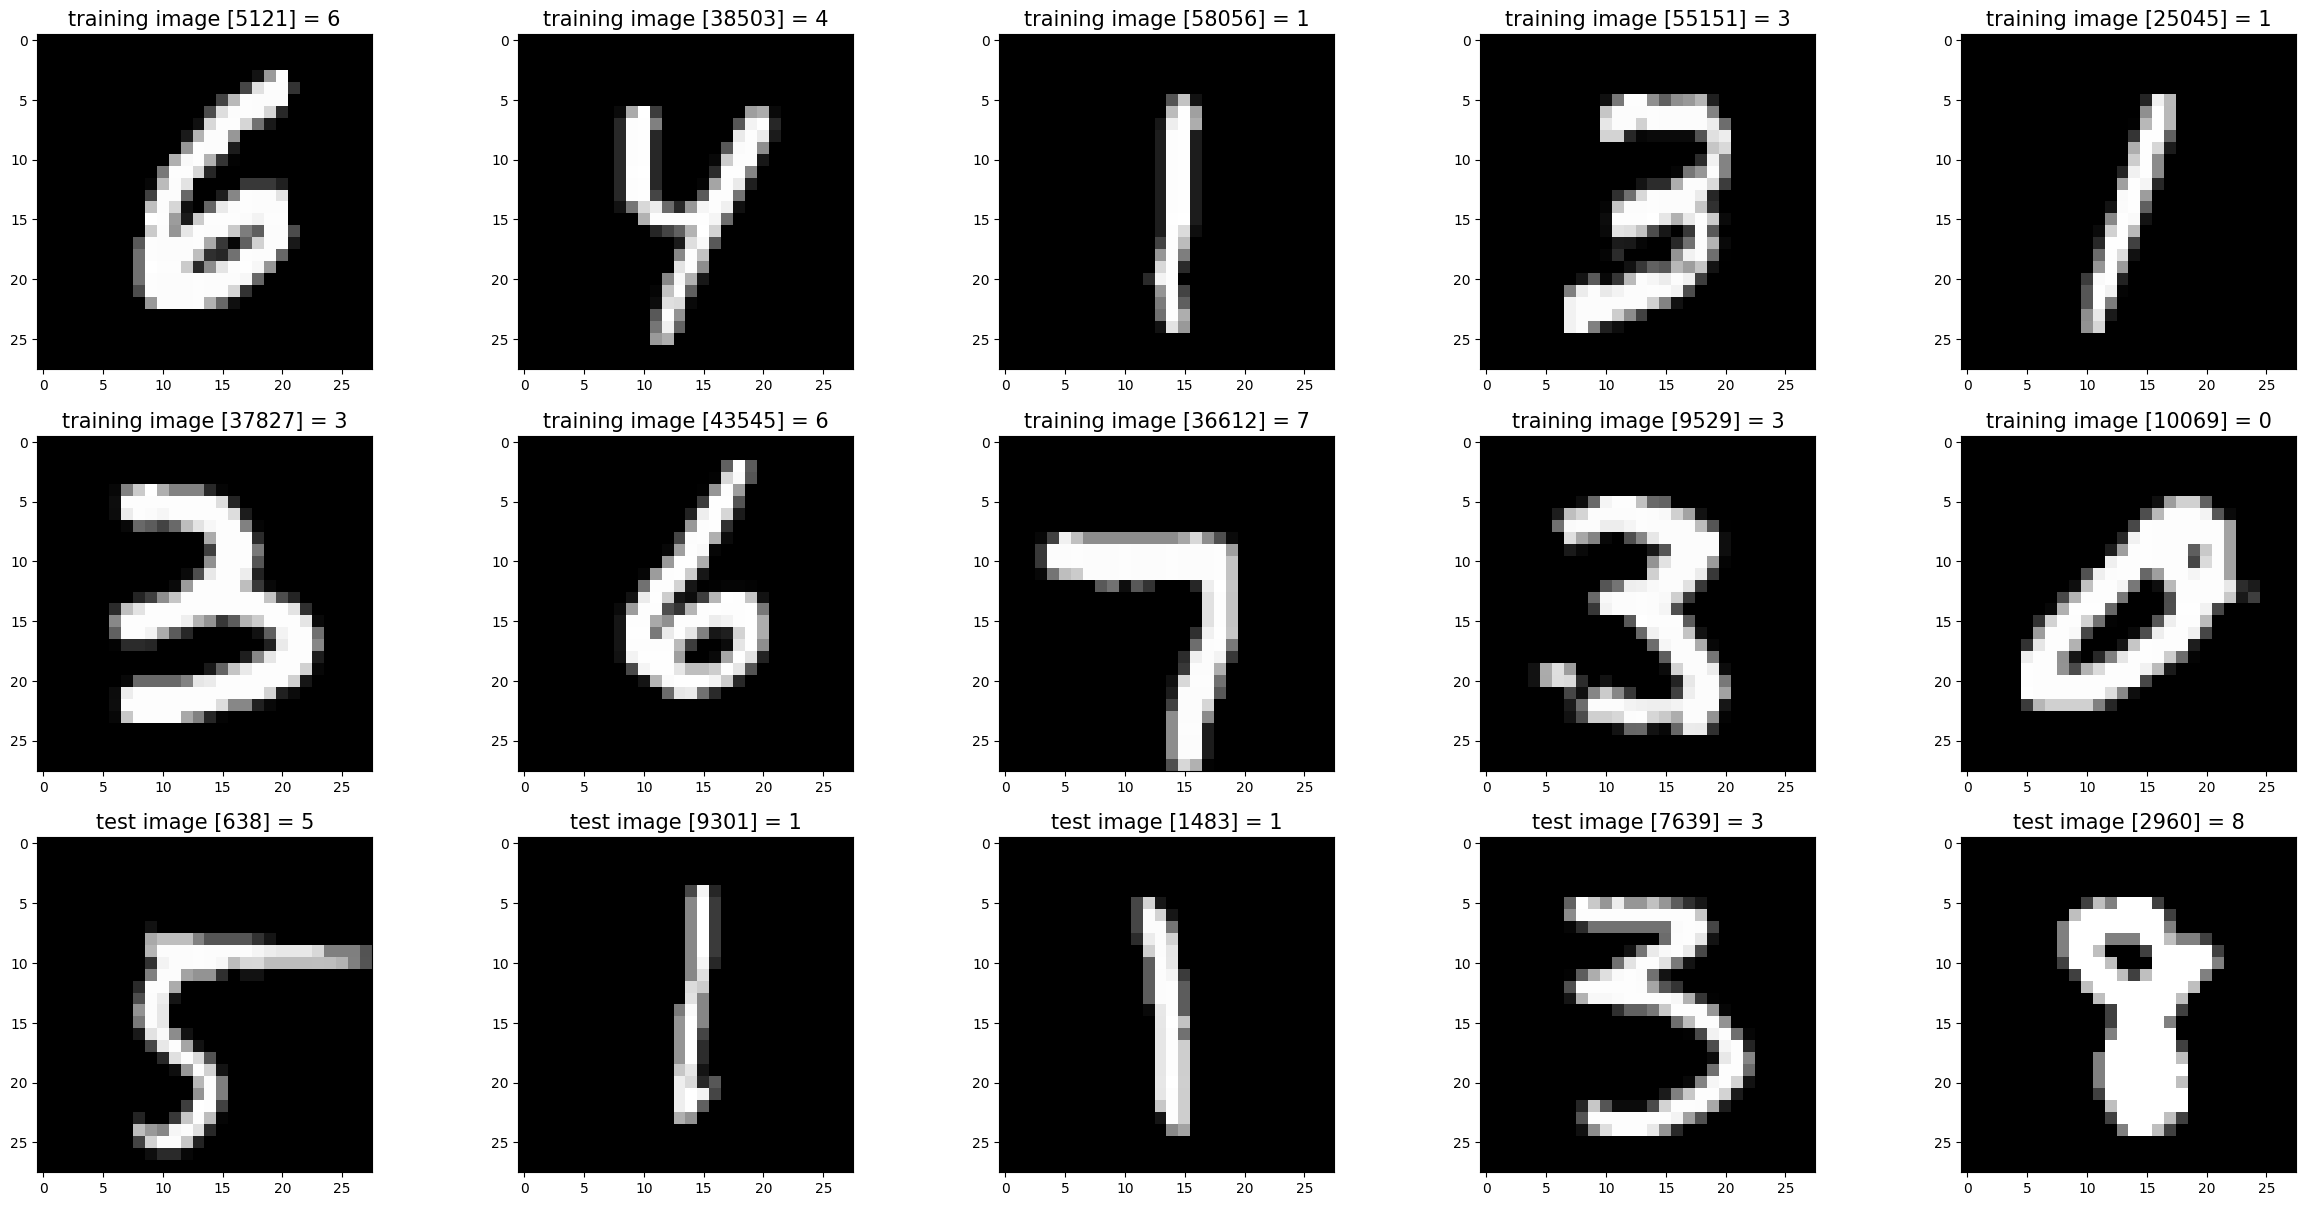

In [5]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = './datasets/mnist'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte')

def show_images(images, title_texts):
  cols = 5
  rows = int(len(images)/cols) + 1
  plt.figure(figsize=(30,20))
  index = 1    
  for x in zip(images, title_texts):        
    image = x[0]        
    title_text = x[1]
    plt.subplot(rows, cols, index)        
    plt.imshow(image, cmap=plt.cm.gray)
    if (title_text != ''):
      plt.title(title_text, fontsize = 15);        
    index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
  r = random.randint(1, 60000)
  images_2_show.append(x_train[r])
  titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
  r = random.randint(1, 10000)
  images_2_show.append(x_test[r])        
  titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [6]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [7]:
import sys
sys.path.append("../../")

from src.core.network_base import LayersNeuralNetwork, softmax, NetworkModule, LossModule, OptimizerModule
from src.core.relu_layer import ReluLayer
from src.core.fc_layer import FullConnectedLayer
from src.core.losses import CrossEntropyLoss
from src.core.optimizers import SGD
from src.core.conv_2d_layer import Convolutional2DLayer
from src.core.maxpool_2d_layer import MaxPool2DLayer
from src.core.flatten_layer import FlattenLayer

In [8]:
def show_loss(epochs: int, train_losses: np.ndarray, test_losses: np.ndarray):
  epochs_array = range(epochs)

  plt.plot(epochs_array, train_losses, label='Training Loss')
  plt.plot(epochs_array, test_losses, label='Validation Loss')
  
  # Add in a title and axes labels
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  
  # Set the tick locations
  # plt.xticks(arange(0, 21, 2))
  
  # Display the plot
  plt.legend(loc='best')

In [9]:
def show_accuracies(epochs: int, train: np.ndarray, test: np.ndarray):
  epochs_array = range(epochs)

  plt.plot(epochs_array, train, label='Training Accuracy')
  plt.plot(epochs_array, test, label='Validation Accuracy')
  
  # Add in a title and axes labels
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  
  # Set the tick locations
  # plt.xticks(arange(0, 21, 2))
  
  # Display the plot
  plt.legend(loc='best')

In [10]:
def prediction(y: np.ndarray) -> np.ndarray:
  s = softmax(y)
  m = np.max(s, axis=1)
  return s == m[:, np.newaxis]

assert np.array_equal(prediction(np.array([[1, 10, 2]])), np.array([[False, True, False]]))
assert np.array_equal(prediction(np.array([[111, 100, 2], [1, 10, 2]])), np.array([[True, False, False], [False, True, False]]))

In [11]:
def calc_accuracy(y_pred: np.ndarray, y_truth: np.ndarray) -> float:
  return np.sum(np.argmax(y_pred, axis=1) == y_truth)

assert calc_accuracy(np.array([[False, True, False]]), np.array([0])) == 0
assert calc_accuracy(np.array([[False, True, False], [False, True, False]]), np.array([0,1])) == 1

In [12]:
a = None
print(f"te_loss {round(a, 2) if a is not None else '-' }")

te_loss -


In [16]:
def generate_string(epoch, train_loss, train_accuracy, test_loss = None, test_accuracy = None):
  return f"Epoch {epoch} tr_loss {round(train_loss, 2)} tr_acc {round(train_accuracy, 2)} " + \
    f"te_loss {round(test_loss, 2) if test_loss is not None else '-'} te_accuracy {round(test_accuracy, 2) if test_accuracy is not None else '-'}"

def train(
  model: NetworkModule,
  epochs: int,
  loss: LossModule,
  optimizer: OptimizerModule,
  x_train_batches: np.ndarray,
  y_train_batches: np.ndarray,
  x_test: np.ndarray,
  y_test: np.ndarray
) -> (List[float], List[float], List[float], List[float]):
    train_losses = []
    test_losses = []
    train_accuraces = []
    test_accuraces = []
    for epoch in range(epochs):
      print(f"====== EPOCH {epoch} ======")
      train_loss = 0
      test_loss = 0
      train_accuracy = 0
      test_accuracy = 0
      count = 0

      for x, y_truth in zip(x_train_batches, y_train_batches):
        optimizer.zero_gradient()
        y_pred = model.forward(x)
        batch_loss = loss(y_pred, y_truth)
        train_loss += batch_loss / len(x_train_batches)
        loss.backward()
        optimizer.step()
        y_pred = prediction(y_pred)
        train_accuracy += calc_accuracy(y_pred, y_truth)
        count += x.shape[0]
      y_pred = model.forward(x_test)
      test_loss = loss(y_pred, y_test)
      y_pred = prediction(y_pred)
      test_accuracy = calc_accuracy(y_pred, y_test) / len(x_test)
      train_losses.append(train_loss)
      test_losses.append(test_loss)
      train_accuraces.append(train_accuracy / count)
      test_accuraces.append(test_accuracy)
      print("Train loss:", train_loss)
      print("Test loss: ", test_loss)
    return (train_losses, test_losses, train_accuraces, test_accuraces)

In [17]:
epochs = 5

batch_size = 4

learning_rate = 0.0001

x_train_1d = x_train.reshape(x_train.shape[0], image_size * image_size) / 255
x_test_1d = x_test.reshape(x_test.shape[0], image_size * image_size) / 255
len_batches = x_train_1d.shape[0] / batch_size
train_batches, test_batches = np.split(x_train_1d, len_batches), np.split(y_train, len_batches)

network = LayersNeuralNetwork([
    FullConnectedLayer(784, 150),
    ReluLayer(),
    FullConnectedLayer(150, 80),
    ReluLayer(),
    FullConnectedLayer(80, 10),
])

loss = CrossEntropyLoss(network)
optimizer = SGD(network, lr=learning_rate)

train_losses, test_losses, train_accuraces, test_accuraces = train(
  network,
  epochs=epochs,
  loss=loss,
  optimizer=optimizer,
  x_train_batches=train_batches,
  y_train_batches = test_batches,
  x_test=x_test_1d,
  y_test=y_test
)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

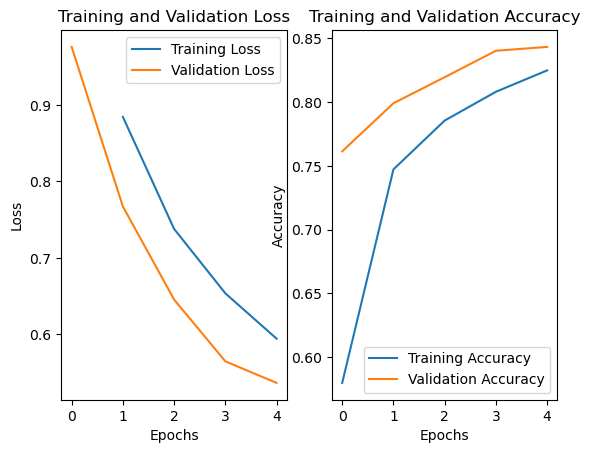

In [ ]:
plt.subplot(1, 2, 1)
show_loss(epochs, train_losses, test_losses)
plt.subplot(1, 2, 2)
show_accuracies(epochs, train_accuraces, test_accuraces)

In [ ]:
epochs = 5

batch_size = 4

learning_rate = 0.0001

x_train_1d = x_train.reshape(x_train.shape[0], image_size * image_size) / 255
x_test_1d = x_test.reshape(x_test.shape[0], image_size * image_size) / 255
len_batches = x_train_1d.shape[0] / batch_size
train_batches, test_batches = np.split(x_train_1d, len_batches), np.split(y_train, len_batches)

network = LayersNeuralNetwork([
    FullConnectedLayer(784, 250),
    ReluLayer(),
    FullConnectedLayer(250, 10),
])

loss = CrossEntropyLoss(network)
optimizer = SGD(network, lr=learning_rate)

train_losses, test_losses, train_accuraces, test_accuraces = train(
  network,
  epochs=epochs,
  loss=loss,
  optimizer=optimizer,
  x_train_batches=train_batches,
  y_train_batches = test_batches,
  x_test=x_test_1d,
  y_test=y_test
)

====== EPOCH 0 ======
nan
3.4819659321464207
====== EPOCH 1 ======
6.1446976204118675
2.4293342020242994
====== EPOCH 2 ======
4.780268803368819
2.7371650464786765
====== EPOCH 3 ======
4.212150635507434
2.554797731175107
====== EPOCH 4 ======
3.9017985808477316
3.142206206199463


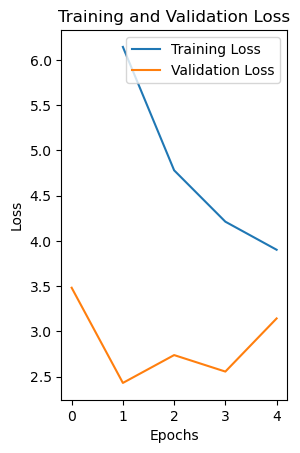

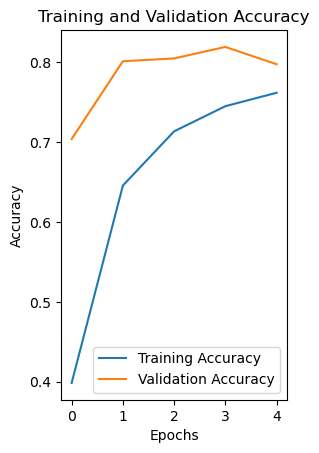

In [ ]:
plt.subplot(1, 2, 1)
show_loss(epochs, train_losses, test_losses)
plt.subplot(1, 2, 2)
show_accuracies(epochs, train_accuraces, test_accuraces)

In [ ]:
epochs = 5

batch_size = 4

learning_rate = 0.0001

x_train_1d = x_train.reshape(x_train.shape[0], image_size * image_size) / 255
x_test_1d = x_test.reshape(x_test.shape[0], image_size * image_size) / 255
len_batches = x_train_1d.shape[0] / batch_size
train_batches, test_batches = np.split(x_train_1d, len_batches), np.split(y_train, len_batches)

network = LayersNeuralNetwork([
    FullConnectedLayer(784, 10),
])

loss = CrossEntropyLoss(network)
optimizer = SGD(network, lr=learning_rate)

train_losses, test_losses, train_accuraces, test_accuraces = train(
  network,
  epochs=epochs,
  loss=loss,
  optimizer=optimizer,
  x_train_batches=train_batches,
  y_train_batches = test_batches,
  x_test=x_test_1d,
  y_test=y_test
)

====== EPOCH 0 ======
3.228163442092901
2.428841517920108
====== EPOCH 1 ======
2.064240959441356
1.6769069404124743
====== EPOCH 2 ======
1.5227898810614018
1.306377887805521
====== EPOCH 3 ======
1.2395931322620262
1.0998106492046553
====== EPOCH 4 ======
1.071580299090536
0.9695157905873523


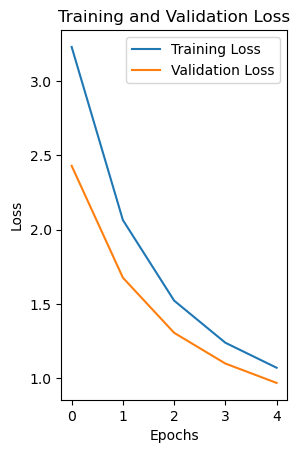

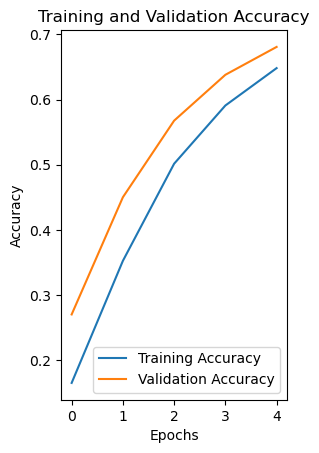

In [ ]:
plt.subplot(1, 2, 1)
show_loss(epochs, train_losses, test_losses)
plt.subplot(1, 2, 2)
show_accuracies(epochs, train_accuraces, test_accuraces)

In [ ]:
epochs = 5

batch_size = 4

learning_rate = 0.0001

conv_train = x_train.transpose(0, 3, 1, 2)
conv_train = conv_train / 255
len_batches = conv_train.shape[0] / batch_size
train_batches, test_batches = np.split(conv_train, len_batches), np.split(y_train, len_batches)
conv_test = x_test.transpose(0, 3, 1, 2)
conv_test = conv_test / 255

conv_network = LayersNeuralNetwork([
    Convolutional2DLayer(1, 10, kernel_size=5, stride=1, padding=2),
    ReluLayer(),
    MaxPool2DLayer(2),
    FlattenLayer(),
    FullConnectedLayer(10 * 14 * 14, 10)
])

loss = CrossEntropyLoss(conv_network)
optimizer = SGD(conv_network, lr=learning_rate)

conv_train_losses, conv_test_losses, conv_train_accuraces, conv_test_accuraces = train(
  conv_network,
  epochs=epochs,
  loss=loss,
  optimizer=optimizer,
  x_train_batches=train_batches,
  y_train_batches = test_batches,
  x_test=conv_test,
  y_test=y_test
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

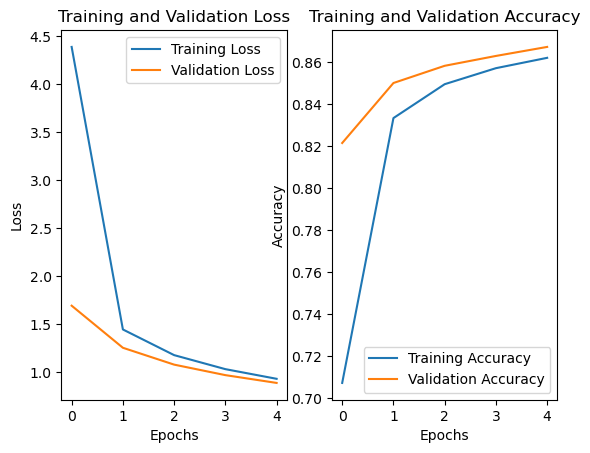

In [ ]:
plt.subplot(1, 2, 1)
show_loss(epochs, conv_train_losses, conv_test_losses)
plt.subplot(1, 2, 2)
show_accuracies(epochs, conv_train_accuraces, conv_test_accuraces)